In [9]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler)
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    make_scorer,
    roc_curve,
    auc)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    learning_curve,
    validation_curve,
    GridSearchCV,
    RandomizedSearchCV,
    HalvingRandomSearchCV)


%matplotlib inline

In [2]:
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)
df.head()
X=df.iloc[:,2:].values
y=df.iloc[:,1].values
le=LabelEncoder()
y=le.fit_transform(y)
le.classes_
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=1)

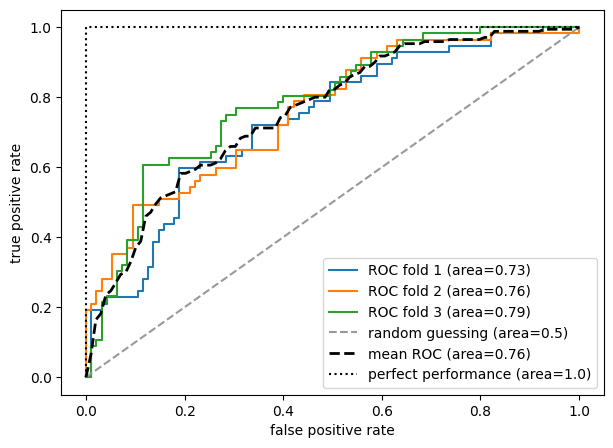

In [5]:
pipe_lr=make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(penalty='l2',random_state=1,solver='lbfgs',C=100.0))
X_train2=X_train[:,[4,14]]
cv=list(StratifiedKFold(n_splits=3).split(X_train,y_train))
fig=plt.figure(figsize=(7,5))
mean_tpr=0.0
mean_fpr=np.linspace(0,1,100)
all_tpr=[]
for i,(train,test) in enumerate(cv):
    probas=pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr,tpr,thresholds=roc_curve(y_train[test],probas[:,1],pos_label=1)
    mean_tpr+=np.interp(mean_fpr,fpr,tpr)
    mean_tpr[0]=0.0
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f'ROC fold {i+1} (area={roc_auc:.2f})')

plt.plot([0,1],[0,1],linestyle='--',color=(0.6,0.6,0.6),label='random guessing (area=0.5)')
mean_tpr/=len(cv)
mean_tpr[-1]=1.0
mean_auc=auc(mean_fpr,mean_tpr)
plt.plot(mean_fpr,mean_tpr,'k--',label=f'mean ROC (area={mean_auc:.2f})',lw=2)
plt.plot([0,0,1],[0,1,1],linestyle=':',color='black',label='perfect performance (area=1.0)')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.show()

In [6]:
pre_scorer=make_scorer(score_func=precision_score,
                       pos_label=1,
                       greater_is_better=True,
                       average='micro')

imbalanced data

In [7]:
X_imb=np.vstack((X[y==0],X[y==1][:40]))
y_imb=np.hstack((y[y==0],y[y==1][:40]))

In [8]:
y_pred=np.zeros(y_imb.shape[0])
np.mean(y_pred==y_imb)*100

89.92443324937027

In [12]:
print('Number of class 1 examples before:',X_imb[y_imb==1].shape[0])
X_upsampled,y_upsampled=resample(X_imb[y_imb==1],
                                 y_imb[y_imb==1],
                                 replace=True,
                                 n_samples=X_imb[y_imb==0].shape[0],
                                 random_state=123)

print('Number of class 1 examples after:',X_upsampled.shape[0])

Number of class 1 examples before: 40
Number of class 1 examples after: 357


In [14]:
x_bal=np.vstack((X_imb[y_imb==0],X_upsampled))
y_bal=np.hstack((y_imb[y_imb==0],y_upsampled))
y_pred=np.zeros(y_bal.shape[0])
np.mean(y_pred==y_bal)*100

50.0